In [14]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Install libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [16]:
# Download Apple stock data
stock_data = yf.download('AAPL', start='2009-11-15', end='2020-07-17')
stock_data.reset_index(inplace=True)

# Create target variable (Increase, Decrease, Neutral)
threshold = 0.01
stock_data['target'] = np.where(
    (stock_data['Close'].shift(-1) - stock_data['Close']) > threshold,
    1,  # Increase
    np.where(
        (stock_data['Close'].shift(-1) - stock_data['Close']) < -threshold,
        2,  # Decrease
        0   # Neutral
    )
)
stock_data.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
scaled_data['target'] = stock_data['target'].values
scaled_data['Date'] = stock_data['Date']

# Split data
train_data = scaled_data[scaled_data['Date'] < '2018-12-01']
val_data = scaled_data[(scaled_data['Date'] >= '2018-12-02') & (scaled_data['Date'] < '2019-09-30')]
test_data = scaled_data[scaled_data['Date'] >= '2019-10-01']

[*********************100%***********************]  1 of 1 completed


In [17]:
stock_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,target
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
0,2009-11-16 00:00:00+00:00,6.225078,7.379643,7.428571,7.321786,7.338571,485206400,1
1,2009-11-17 00:00:00+00:00,6.236225,7.392857,7.408571,7.321429,7.360000,396513600,2
2,2009-11-18 00:00:00+00:00,6.204893,7.355714,7.392857,7.285714,7.376429,374320800,2
3,2009-11-19 00:00:00+00:00,6.040700,7.161071,7.307500,7.135714,7.307500,542326400,2
4,2009-11-20 00:00:00+00:00,6.022927,7.140000,7.156786,7.062857,7.112500,406666400,1


In [18]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data.iloc[index:index + self.sequence_length, :-2].values
        y = self.data.iloc[index + self.sequence_length]['target']
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

sequence_length = 70
train_dataset = StockDataset(train_data, sequence_length)
val_dataset = StockDataset(val_data, sequence_length)
test_dataset = StockDataset(test_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# Hyperparameters
input_size = 5  
hidden_size = 90
num_layers = 1
num_classes = 3 
num_epochs = 20 
learning_rate = 0.003 
batch_size = 32

In [20]:
# LTSM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.softmax(out)

In [21]:
# Train model
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

Epoch 1/20, Train Loss: 0.9882, Val Loss: 0.9818
Epoch 2/20, Train Loss: 0.9778, Val Loss: 0.9734
Epoch 3/20, Train Loss: 0.9763, Val Loss: 0.9735
Epoch 4/20, Train Loss: 0.9753, Val Loss: 0.9811
Epoch 5/20, Train Loss: 0.9754, Val Loss: 0.9788
Epoch 6/20, Train Loss: 0.9761, Val Loss: 0.9711
Epoch 7/20, Train Loss: 0.9745, Val Loss: 0.9768
Epoch 8/20, Train Loss: 0.9761, Val Loss: 0.9766
Epoch 9/20, Train Loss: 0.9749, Val Loss: 0.9712
Epoch 10/20, Train Loss: 0.9745, Val Loss: 0.9756
Epoch 11/20, Train Loss: 0.9768, Val Loss: 0.9751
Epoch 12/20, Train Loss: 0.9739, Val Loss: 0.9710
Epoch 13/20, Train Loss: 0.9742, Val Loss: 0.9742
Epoch 14/20, Train Loss: 0.9752, Val Loss: 0.9743
Epoch 15/20, Train Loss: 0.9763, Val Loss: 0.9709
Epoch 16/20, Train Loss: 0.9747, Val Loss: 0.9764
Epoch 17/20, Train Loss: 0.9738, Val Loss: 0.9707
Epoch 18/20, Train Loss: 0.9742, Val Loss: 0.9722
Epoch 19/20, Train Loss: 0.9741, Val Loss: 0.9725
Epoch 20/20, Train Loss: 0.9743, Val Loss: 0.9706


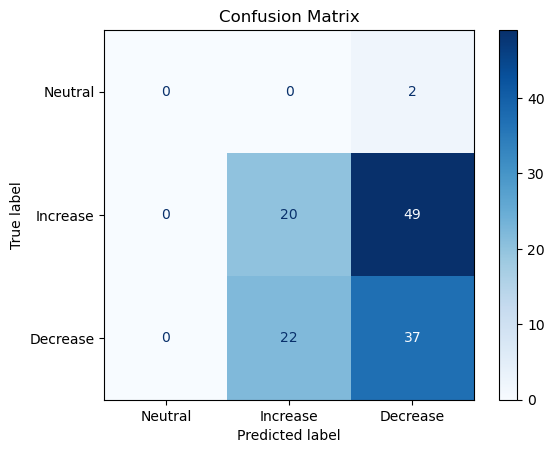

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         2
    Increase       0.48      0.29      0.36        69
    Decrease       0.42      0.63      0.50        59

    accuracy                           0.44       130
   macro avg       0.30      0.31      0.29       130
weighted avg       0.44      0.44      0.42       130



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


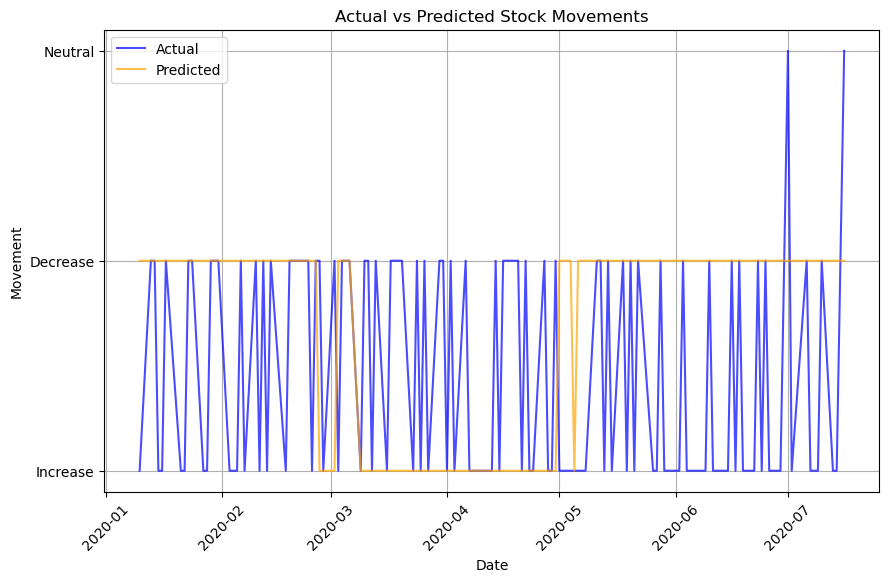

In [22]:
# Evaluate model
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Model Evaluation
def evaluate_and_visualize(model, test_loader, sequence_length, test_data):
    model.eval()
    all_preds = []
    all_targets = []

    # Collect predictions and true labels
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    # Show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Neutral', 'Increase', 'Decrease'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=['Neutral', 'Increase', 'Decrease']))

    # Align dates with sequence length and predictions
    dates = test_data['Date'][sequence_length:].reset_index(drop=True)

    # Create a DF for visualization
    results_df = pd.DataFrame({
        'Actual': all_targets,
        'Predicted': all_preds,
        'Date': dates
    })

    # Map numeric classes to labels
    class_labels = {0: 'Neutral', 1: 'Increase', 2: 'Decrease'}
    results_df['Actual'] = results_df['Actual'].map(class_labels)
    results_df['Predicted'] = results_df['Predicted'].map(class_labels)

    # Plot actual vs predicted time series data
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='blue', alpha=0.7)
    plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', color='orange', alpha=0.7)
    plt.legend()
    plt.title('Actual vs Predicted Stock Movements')
    plt.xlabel('Date')
    plt.ylabel('Movement')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
# LSTM model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# Train model
train_losses, val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs, learning_rate)

# Evaluate & visualize
evaluate_and_visualize(lstm_model, test_loader, sequence_length, test_data)

In [23]:
def visualize_predictions(model, test_loader, test_data, sequence_length):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

    # Align predictions with the test data
    aligned_test_data = test_data.iloc[sequence_length:].copy()
    aligned_test_data['Predicted'] = all_preds[:len(aligned_test_data)]

    # Plot predictions and stock price
    plt.figure(figsize=(12, 6))
    plt.plot(aligned_test_data['Date'], aligned_test_data['Close'], label='Stock Price (Close)', color='black')

    plt.scatter(
        aligned_test_data['Date'][aligned_test_data['Predicted'] == 0],
        aligned_test_data['Close'][aligned_test_data['Predicted'] == 0],
        color='blue', label='Predicted Neutral', alpha=0.6
    )
    plt.scatter(
        aligned_test_data['Date'][aligned_test_data['Predicted'] == 1],
        aligned_test_data['Close'][aligned_test_data['Predicted'] == 1],
        color='green', label='Predicted Increase', alpha=0.6
    )
    plt.scatter(
        aligned_test_data['Date'][aligned_test_data['Predicted'] == 2],
        aligned_test_data['Close'][aligned_test_data['Predicted'] == 2],
        color='red', label='Predicted Decrease', alpha=0.6
    )

    plt.legend()
    plt.title('Stock Price with Predicted Movements')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

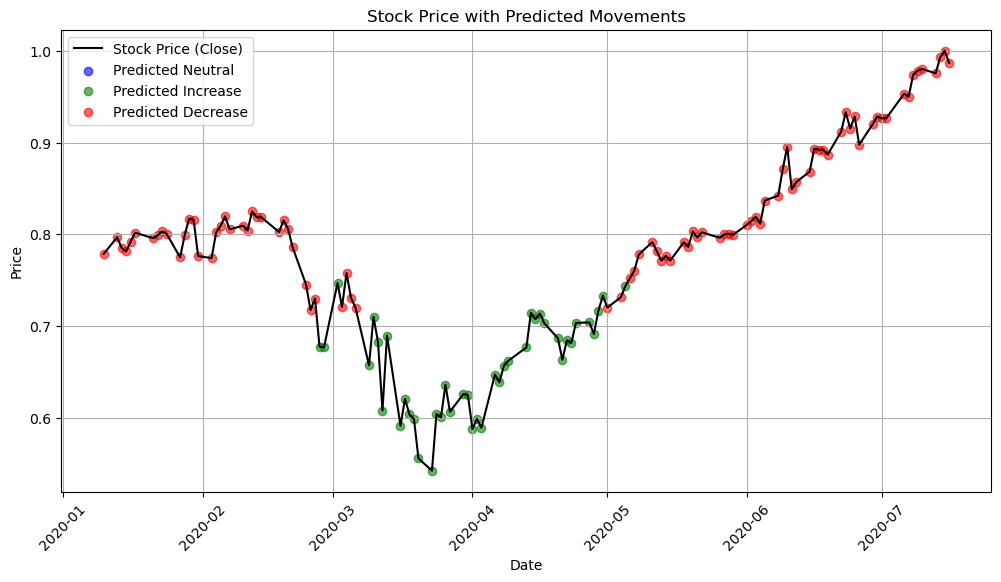

In [24]:
visualize_predictions(lstm_model, test_loader, test_data, sequence_length)

In [25]:
print(train_data['target'].value_counts())

target
1    1156
2    1043
0      78
Name: count, dtype: int64
